## Goal: What is Fst score per exon + ss (+-2bp)
For exons that are 
* unique to one population or the other
* shared between the population

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot


p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [76]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [77]:
df = pd.read_csv(proc_cfg(config['lr']['exons_ss_in_pops_fsts_summary'], od),
                 sep='\t')
df.rename({'ThickStart':'eid',
           'ThickEnd':'novelty',
           'ItemRGB':'pop1_det',
           'BlockCount':'pop2_det'}, 
          axis=1, inplace=True)

# set all <0 fsts --> 0 https://www.biostars.org/p/132253/
df.loc[df.fst<0, 'fst'] = 0

In [78]:
gb_cols = ['eid', 'novelty', 'pop1_det', 'pop2_det',
            'pop1', 'pop2']
keep_cols = gb_cols+['fst']


# make sure there are no dupe eid + contrast + var. posiition
# assert len(df[gb_cols+['End_b', 'Start_b']].drop_duplicates().index) == len(df.index) # oop there's a bug somewhere upstream w/ the vcf processing

print('REMOVE ME WHEN FABIEN FIXES FST STUFF')
print(len(df.index))
df = df.drop_duplicates(subset=gb_cols+['End_b', 'Start_b'], keep=False)
print(len(df.index))

# add up each fst per contrast and exon
df = df.groupby(gb_cols).sum().reset_index().rename({'fst':'fst_sum'}, axis=1)

REMOVE ME WHEN FAsBIEN FIXES FST STUFF
1370855
1370855


,eid,novelty,pop1_det,pop2_det,pop1,pop2,Start,End,End_b,fst_sum,Start_b,elen,avg_fst_per_base_x100
0,GL000008.2_+_135133_135173,Known,False,True,CEU,PEL,135133,135173,-1,0.0,-1,40,0.0
1,GL000008.2_+_135133_135173,Known,False,True,ITU,PEL,135133,135173,-1,0.0,-1,40,0.0
2,GL000008.2_+_135133_135173,Known,False,True,LWK,PEL,135133,135173,-1,0.0,-1,40,0.0
3,GL000008.2_+_135133_135173,Known,True,False,PEL,YRI,135133,135173,-1,0.0,-1,40,0.0
4,GL000008.2_+_155429_155531,Known,False,True,CEU,ITU,155429,155531,-1,0.0,-1,102,0.0


In [79]:
# df.loc[df[gb_cols+['End_b', 'Start_b']].duplicated(keep=False)].sorts_values(by=gb_cols+['End_b', 'Start_b'])

In [80]:
# get length of each exon
df['elen'] = df['End']-df['Start']

# and get avg. Fst per base in each exon+ss
df['avg_fst_per_base_x100'] = (df['fst_sum']/df['elen'])*100

# assert len(df.loc[df.avg_fst_per_base_x100>1]) == 0

In [81]:
# df.loc[df.avg_fst_per_base_x100>1]

[Text(0.5, 15.700000000000003, 'Population 2'),
 Text(15.7, 0.5, 'Popluation 1'),
 Text(0.5, 1.0, 'Fsts of exonic SNPs based on\ndetected populations')]

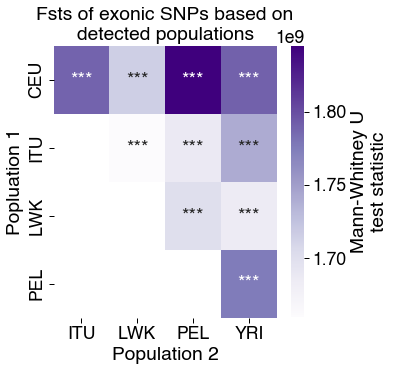

In [96]:
# loop through each contrast
stat_df = pd.DataFrame()
for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                      df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
    temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
    temp.rename({'pop1_det':pop1,
             'pop2_det':pop2}, axis=1, inplace=True)
    temp.set_index([pop1, pop2], inplace=True)
    
    assert len(temp.index) == len(temp.eid.unique()) # make sure only one exon per thing    
    
    temp.reset_index(inplace=True)
    temp['med_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100'].transform('median')
    temp['mean_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100'].transform('mean')

    temp[[pop1, pop2, 'med_per_group']].drop_duplicates()
    temp[[pop1, pop2, 'mean_per_group']].drop_duplicates()

    temp['thing'] = ''
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
    temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     

    temp['thing2'] = 'unique'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing2'] = 'shared'
    
    temp['avg_fst_per_base_x100_10'] = 10*temp['avg_fst_per_base_x100']
    
    x = temp.loc[temp.thing2=='unique','avg_fst_per_base_x100'].tolist() # hyp. --> greater
    y = temp.loc[temp.thing2=='shared','avg_fst_per_base_x100'].tolist()

    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    temp3 = pd.DataFrame(data=[[pop1, pop2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)

# fdr correction
from statsmodels.stats.mulatitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Fsts of exonic SNPs based on\ndetected populations')

In [98]:
stat_df

,pop1,pop2,stat,pval,adj_pval,sig_annot
0,CEU,PEL,1.844989e+09,1.785903e-22,4.464757e-22,***
0,ITU,PEL,1.687167e+09,9.579929e-09,1.064437e-08,***
0,LWK,PEL,1.700285e+09,1.146809e-21,2.293618e-21,***
0,PEL,YRI,1.775543e+09,1.096440e-11,1.370550e-11,***
0,CEU,ITU,1.789108e+09,5.320003e-27,2.660002e-26,***
0,ITU,LWK,1.659421e+09,4.964599e-24,1.654866e-23,***
0,ITU,YRI,1.741138e+09,9.022953e-05,9.022953e-05,***
0,CEU,LWK,1.714859e+09,3.006443e-35,3.006443e-34,***
0,CEU,YRI,1.790159e+09,8.589086e-21,1.431514e-20,***
0,LWK,YRI,1.685037e+09,1.583893e-12,2.262704e-12,***


In [97]:
stat_df1

pop2,ITU,LWK,PEL,YRI
pop1,,,,
CEU,1.789108e+09,1.714859e+09,1.844989e+09,1.790159e+09
ITU,NaN,1.659421e+09,1.687167e+09,1.741138e+09
LWK,NaN,NaN,1.700285e+09,1.685037e+09
PEL,NaN,NaN,NaN,1.775543e+09


In [95]:
annot_df.head()

pop2,ITU,LWK,PEL,YRI
pop1,,,,
CEU,***,***,***,***
ITU,NaN,***,***,***
LWK,NaN,NaN,***,***
PEL,NaN,NaN,NaN,***


## For uniq exons ONLY, do novel ones have higher Fsts than known ones?

In [100]:
# loop through each contrast
stat_df = pd.DataFrame()
for pop1, pop2 in zip(df[['pop1', 'pop2']].drop_duplicates()['pop1'].tolist(),
                      df[['pop1', 'pop2']].drop_duplicates()['pop2'].tolist()):
    temp = df.loc[(df.pop1==pop1)&(df.pop2==pop2)]
    temp.rename({'pop1_det':pop1,
             'pop2_det':pop2}, axis=1, inplace=True)
    temp.set_index([pop1, pop2], inplace=True)
    
    assert len(temp.index) == len(temp.eid.unique()) # make sure only one exon per thing    
    
    temp.reset_index(inplace=True)
    temp['med_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100'].transform('median')
    temp['mean_per_group'] = temp.groupby([pop1, pop2])['avg_fst_per_base_x100'].transform('mean')

    temp[[pop1, pop2, 'med_per_group']].drop_duplicates()
    temp[[pop1, pop2, 'mean_per_group']].drop_duplicates()

    temp['thing'] = ''
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing'] = f'{pop1}_{pop2}'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==False), 'thing'] = f'{pop1}'
    temp.loc[(temp[pop1]==False)&(temp[pop2]==True), 'thing'] = f'{pop2}'     

    temp['thing2'] = 'unique'
    temp.loc[(temp[pop1]==True)&(temp[pop2]==True), 'thing2'] = 'shared'
    
    temp['avg_fst_per_base_x100_10'] = 10*temp['avg_fst_per_base_x100']
    
    x = temp.loc[temp.thing2=='unique','avg_fst_per_base_x100'].tolist() # hyp. --> greater
    y = temp.loc[temp.thing2=='shared','avg_fst_per_base_x100'].tolist()

    stat, pval = st.mannwhitneyu(x, y, alternative='greater')
    temp3 = pd.DataFrame(data=[[pop1, pop2, stat, pval]], 
                         columns=['pop1', 'pop2', 'stat', 'pval'])
    stat_df = pd.concat([stat_df, temp3], axis=0)

# fdr correction
from statsmodels.stats.mulatitest import multipletests
_, adj_p_vals, _, _ = multipletests(stat_df.pval.tolist(), method='fdr_bh')
stat_df['adj_pval'] = adj_p_vals
stat_df.head()

# add sig. annotation
# * <= 0.05
# ** <= 0.01
# *** <= 0.001
stat_df['sig_annot'] = ''
# stat_df.loc[stat_df.pval <= 0.05, 'sig_annot'] = '*'
# stat_df.loc[stat_df.pval <= 0.01, 'sig_annot'] = '**'
# stat_df.loc[stat_df.pval <= 0.001, 'sig_annot'] = '***'
stat_df.loc[stat_df.adj_pval <= 0.05, 'sig_annot'] = '*'
stat_df.loc[stat_df.adj_pval <= 0.01, 'sig_annot'] = '**'
stat_df.loc[stat_df.adj_pval <= 0.001, 'sig_annot'] = '***'

# pivot x2 to get a stat and annot df to plot
stat_df1 = stat_df.pivot(index='pop1', columns='pop2', values='stat')
annot_df = stat_df.pivot(index='pop1', columns='pop2', values='sig_annot')

ax = sns.heatmap(stat_df1, cmap='Purples',
            annot=annot_df,
            fmt='',
            cbar_kws={'label': 'Mann-Whitney U\ntest statistic'})

# labels need them
ax.set(xlabel='Population 2',
       ylabel='Popluation 1',
       title='Fsts of exonic SNPs based on\ndetected populations')

,eid,novelty,pop1_det,pop2_det,pop1,pop2,Start,End,End_b,fst_sum,Start_b,elen,avg_fst_per_base_x100
0,GL000008.2_+_135133_135173,Known,False,True,CEU,PEL,135133,135173,-1,0.0,-1,40,0.0
1,GL000008.2_+_135133_135173,Known,False,True,ITU,PEL,135133,135173,-1,0.0,-1,40,0.0
2,GL000008.2_+_135133_135173,Known,False,True,LWK,PEL,135133,135173,-1,0.0,-1,40,0.0
3,GL000008.2_+_135133_135173,Known,True,False,PEL,YRI,135133,135173,-1,0.0,-1,40,0.0
4,GL000008.2_+_155429_155531,Known,False,True,CEU,ITU,155429,155531,-1,0.0,-1,102,0.0


Text(0.5, 0.98, 'Exon Fsts by exon detection')

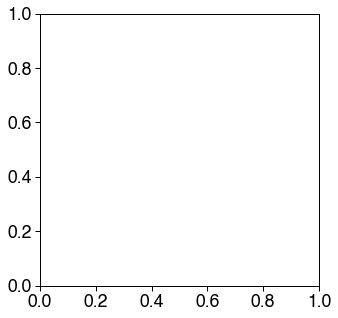

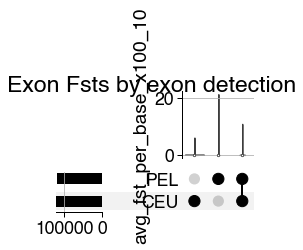

In [70]:
# init_plot_settings()
# upset = upsetplot.UpSet(temp, intersection_plot_elements=0)  # disable the default bar chart
# upset.add_catplot(
#     kind='violin',
#     value='avg_fst_per_base_x100_10')
# ax = plt.gca()
# upset.plot()
# plt.suptitle('Exon Fsts by exon detection')
# # plt.savefig('td_personal_perc_novel_pers_spec_sjs.pdf', dpi=500)

,CEU,PEL,mean_per_group
0,False,True,0.016942
2,True,True,0.012500
8,True,False,0.015274


,CEU,PEL,eid,novelty,pop1,pop2,Start,End,End_b,fst_sum,Start_b,elen,avg_fst_per_base_x100,avg_fst_per_base_x100_10,med_per_group,mean_per_group,thing
0,False,True,GL000008.2_+_135133_135173,Known,CEU,PEL,135133,135173,-1,0.0,-1,40,0.0,0.0,0.0,0.016942,PEL
1,False,True,GL000008.2_+_155429_155531,Known,CEU,PEL,155429,155531,-1,0.0,-1,102,0.0,0.0,0.0,0.016942,PEL
2,True,True,GL000008.2_+_83926_84014,Known,CEU,PEL,83926,84014,-1,0.0,-1,88,0.0,0.0,0.0,0.012500,CEU_PEL
3,True,True,GL000008.2_+_83926_84145,Known,CEU,PEL,83926,84145,-1,0.0,-1,219,0.0,0.0,0.0,0.012500,CEU_PEL
4,False,True,GL000008.2_+_85442_85477,Known,CEU,PEL,85442,85477,-1,0.0,-1,35,0.0,0.0,0.0,0.016942,PEL


,CEU,PEL,eid,novelty,pop1,pop2,Start,End,End_b,fst_sum,Start_b,elen,avg_fst_per_base_x100,avg_fst_per_base_x100_10,med_per_group,mean_per_group,thing,thing2
0,False,True,GL000008.2_+_135133_135173,Known,CEU,PEL,135133,135173,-1,0.0,-1,40,0.0,0.0,0.0,0.016942,PEL,unique
1,False,True,GL000008.2_+_155429_155531,Known,CEU,PEL,155429,155531,-1,0.0,-1,102,0.0,0.0,0.0,0.016942,PEL,unique
2,True,True,GL000008.2_+_83926_84014,Known,CEU,PEL,83926,84014,-1,0.0,-1,88,0.0,0.0,0.0,0.012500,CEU_PEL,shared
3,True,True,GL000008.2_+_83926_84145,Known,CEU,PEL,83926,84145,-1,0.0,-1,219,0.0,0.0,0.0,0.012500,CEU_PEL,shared
4,False,True,GL000008.2_+_85442_85477,Known,CEU,PEL,85442,85477,-1,0.0,-1,35,0.0,0.0,0.0,0.016942,PEL,unique


In [75]:
x = temp.loc[temp.thing2=='unique','avg_fst_per_base_x100'].tolist() # hyp. --> greater
y = temp.loc[temp.thing2=='shared','avg_fst_per_base_x100'].tolist()


stat, pval = st.mannwhitneyu(x, y, alternative='greater')
print(stat)
print(pval)

1844988591.5
1.7859027243052379e-22
